In [1]:
import pandas as pd

In [2]:

df = pd.read_csv('sab-bma.csv')


In [3]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...
...,...,...
9735,CCATTTCCCACACGAGAGCCCGGCTTTCCTGTCACATTTGGTAAGG...,AGGCCTAACGCCTTTATTATATAACCACTCTTAGCCCATAGGACTA...
9736,TTGATAGGTCATTTACGGCGCGCGAGCCGCATAGGGTAGTAGGGAT...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGATATGGGCCC...
9737,GTTAGTGACCTAGCCGGGCTATTGGCGAGACTTACCTAACGGAGTT...,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...
9738,CTGTTCAGACGACGATATACGGCCCTGCATTGTATTGTAAAAGCGT...,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...


In [4]:
from tqdm import tqdm


In [5]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [6]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [7]:
import difflib


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [9]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 9740/9740 [00:00<00:00, 50497.37it/s]


[7178, 7133, 7170, 7176, 7195, 7151, 7199, 7166, 7138, 7218, 7227, 7260, 7232, 7126, 7206, 7157, 7228, 7177, 7146, 7282, 7217, 7187, 7239, 7309, 7195, 7229, 7180, 7191, 7221, 7190, 7204, 7207, 7220, 7157, 7254, 7212, 7273, 7194, 7195, 7143, 7174, 7226, 7252, 7122, 7211, 7106, 7245, 7246, 7163, 7256, 7223, 7236, 7153, 7195, 7225, 7251, 7249, 7268, 7328, 7207, 7248, 7176, 7256, 7215, 7204, 7145, 7225, 7269, 7170, 7200, 7302, 7213, 7226, 7177, 7229, 7165, 7225, 7211, 7292, 7184, 7283, 7182, 7195, 7240, 7159, 7257, 7259, 7241, 7147, 7131, 7231, 7178, 7226, 7185, 7211, 7132, 7099, 7205, 7192, 7233, 7175, 7140, 7190, 7232, 7231, 7195, 7133, 7146, 7160, 7125]


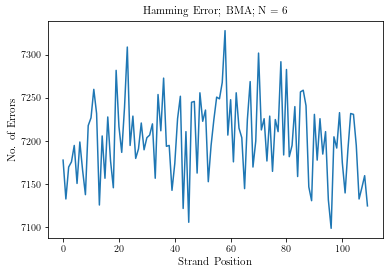

In [10]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; BMA; N = 6', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov6-sab-bma-hamming.pdf', bbox_inches='tight')

In [11]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 9740/9740 [00:19<00:00, 489.49it/s]


In [12]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


 -> AAGAC 6
 -> TCCAC 6
CTCCT ->  6
 -> AAGTT 6
 -> CACCA 6
CGAGG ->  6
 -> CTTGC 6
 -> GCCAG 6
T -> AGGA 6
 -> TTACC 6
TCCCT ->  6
GAGGG ->  6
AGGGA ->  6
GCAAA ->  6
AATTA ->  6
G -> ACAT 6
C -> GTGA 6
AAAC -> G 6
G -> ACCA 6
 -> CTGGC 6
C -> TAG 6
CGCA -> T 6
T -> ACAA 6
AA -> TCC 6
CGCC -> A 6
CTAGC ->  6
TCCC -> G 6
CC -> GGG 6
GAGGA ->  6
CATTT ->  6
CGCCC ->  6
T -> AAAA 6
TGATG ->  6
 -> TGGCT 6
GATC ->  6
 -> AGGTT 6
 -> TCCCT 6
T -> CAG 6
TTT -> CC 6
TCCTC ->  6
 -> GATGAA 6
AC -> GT 6
 -> CTTAA 6
 -> AAGC 6
AGAGG ->  6
T -> CGCC 6
 -> AAGAA 6
AAGGG -> C 6
 -> TGGGG 6
AA -> GGC 6
C -> GGGT 6
C -> TATT 6
CC -> GAG 6
CGAT ->  6
T -> AGC 6
 -> GAACC 6
 -> TCTCC 6
GGTCT ->  6
 -> GGACG 6
CCAAG ->  6
AAATG ->  6
GAATT ->  6
 -> TCGCG 6
TTTAT ->  6
 -> TTGGA 6
AAGA -> T 6
TT -> CGC 6
GAACG ->  6
 -> CCACT 6
 -> GTGCT 6
 -> ACGGAG 6
AACTA ->  6
GTGT -> A 6
A -> CGCT 6
 -> AATTC 6
A -> GTGT 6
 -> TCAAT 6
TTAT -> C 6
TT -> AGG 6
TTTGG ->  6
TCTC -> G 6
ATGAT ->  6
TCACC ->  6
 -> CCGC

C -> G @ 8 6
T -> G @ 101 6
CA ->  @ 95 6
G -> A @ 3 6
C -> G @ 31 6
C -> G @ 19 6
G -> C @ 43 6
G -> C @ 48 6
CA ->  @ 31 6
G -> A @ 35 6
G -> A @ 40 6
GG ->  @ 18 6
T -> C @ 80 6
T -> G @ 103 6
 -> CG @ 103 6
G -> C @ 63 6
G -> C @ 92 6
G -> C @ 62 6
C -> G @ 32 6
G -> CT @ 110 6
G -> C @ 60 6
C -> G @ 39 6
CA ->  @ 6 6
C -> G @ 65 6
C -> G @ 56 6
 -> AA @ 106 6
T -> C @ 23 6
T -> G @ 41 6
CA ->  @ 28 6
 -> AAA @ 2 6
 -> AA @ 100 6
G -> C @ 78 6
T -> C @ 60 6
T -> C @ 69 6
C -> G @ 95 6
G -> A @ 104 6
 -> AAA @ 4 6
T -> C @ 31 6
GG ->  @ 23 6
 -> AAA @ 18 6
T -> C @ 96 6
T -> G @ 48 6
G -> A @ 14 6
G -> A @ 16 6
C -> G @ 48 6
T -> G @ 18 6
C -> G @ 62 6
C -> G @ 9 6
T -> C @ 21 6
GG ->  @ 22 6
C -> G @ 45 6
G -> A @ 23 6
G -> A @ 27 6
T -> G @ 54 6
T -> G @ 22 6
C -> G @ 27 6
CG ->  @ 5 6
 -> CG @ 106 6
 -> TAC @ 0 6
 -> CA @ 43 6
 -> GG @ 43 6
 -> CAA @ 4 6
C -> T @ 46 6
 -> CA @ 32 6
 -> GG @ 31 6
 -> CA @ 29 6
 -> GG @ 25 6
 -> GG @ 19 6
 -> TA @ 54 6
 -> CA @ 21 6
 -> GG @ 11 6
T

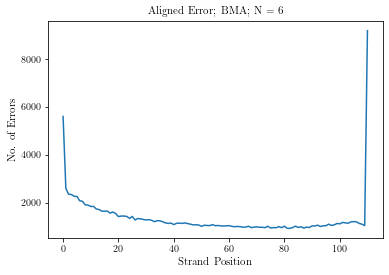

In [13]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; BMA; N = 6', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov6-sab-bma-aligned.pdf', bbox_inches='tight')

In [14]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [15]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [16]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[174, 49, 65, 73, 74, 70, 59, 55, 60, 49, 52, 44, 49, 51, 40, 43, 47, 32, 32, 29, 37, 38, 33, 32, 24, 34, 36, 36, 24, 42, 29, 34, 24, 28, 28, 25, 26, 27, 21, 27, 26, 18, 22, 27, 28, 23, 22, 24, 20, 24, 22, 25, 15, 19, 23, 28, 25, 22, 22, 24, 26, 19, 28, 22, 32, 23, 27, 16, 23, 19, 27, 23, 28, 22, 23, 15, 23, 22, 19, 26, 23, 22, 22, 22, 23, 25, 15, 18, 12, 16, 17, 23, 21, 21, 32, 28, 28, 33, 21, 23, 34, 30, 32, 24, 24, 41, 28, 22, 32, 55, 69]
[225, 53, 60, 81, 79, 61, 57, 69, 47, 52, 38, 39, 42, 34, 41, 47, 40, 35, 44, 43, 29, 48, 39, 31, 41, 39, 21, 32, 32, 28, 22, 36, 29, 24, 36, 29, 26, 26, 24, 26, 30, 24, 26, 24, 28, 21, 20, 15, 23, 25, 17, 22, 20, 18, 23, 29, 20, 25, 22, 26, 23, 21, 23, 21, 19, 20, 22, 27, 21, 17, 26, 23, 14, 21, 20, 17, 25, 21, 24, 24, 20, 17, 20, 16, 22, 15, 20, 15, 22, 19, 16, 17, 19, 24, 24, 30, 25, 24, 24, 24, 26, 25, 33, 28, 28, 43, 37, 29, 28, 50, 47]
[211, 47, 61, 61, 54, 59, 57, 56, 59, 49, 41, 42, 47, 34, 49, 40, 51, 36, 32, 39, 35, 32, 35, 31, 28, 30, 32

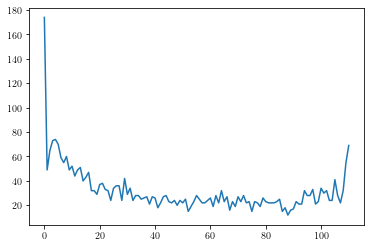

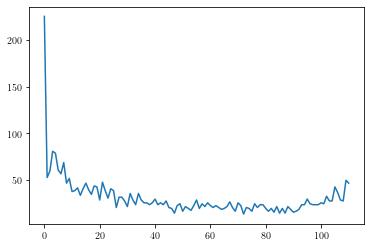

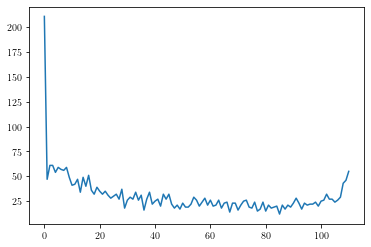

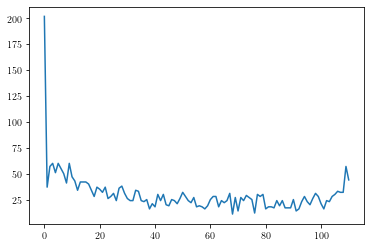

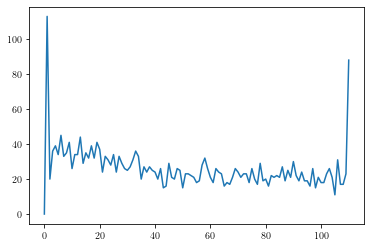

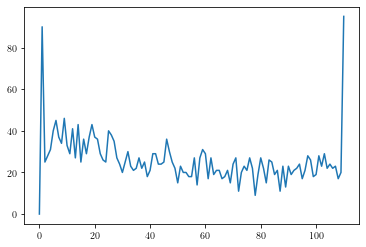

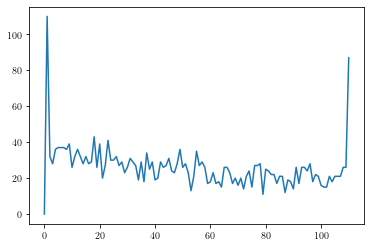

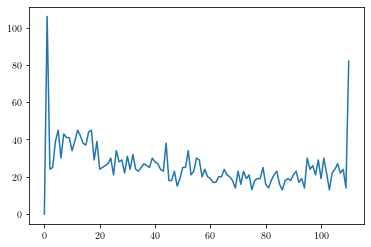

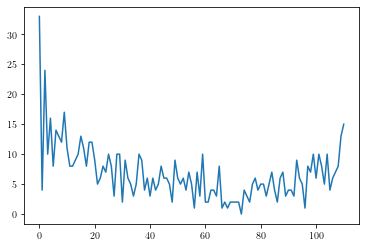

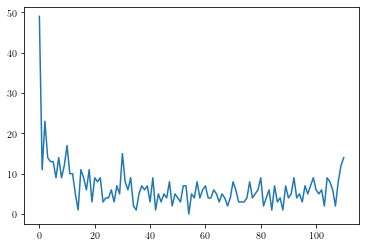

In [17]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [18]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)